# Link Prediction

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import from_networkx, to_networkx, negative_sampling
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder
import torch
import numpy as np
import torch.nn as nn
from torch_geometric.nn import GCNConv, to_hetero_with_bases, GATConv
from sklearn.metrics import confusion_matrix
import seaborn as sns
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score
from torch import Tensor
import torch.nn.functional as F

## 1. data analysis

In [2]:
g = nx.read_graphml("airportsAndCoordAndPop.graphml")

In [3]:
# nx.draw_networkx(g) # Take to long time, not a good visualisation

In [4]:
print(len(g.nodes))
print(len(g.edges))

3363
13547


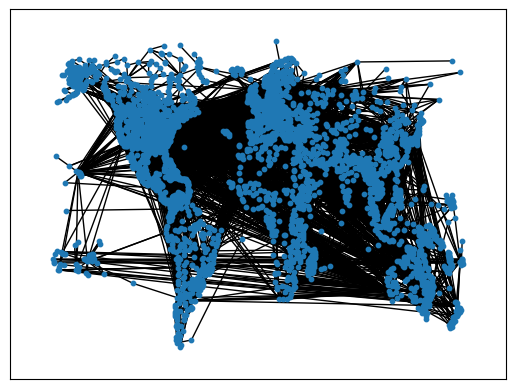

In [5]:
pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
nx.draw_networkx(g, pos=pos, node_size=10, with_labels=False)

With Gephi we have optain this graph:
![](./gephi_analyse/airports_coord_pop_graph.svg)

In [6]:
g.nodes(data=True)

NodeDataView({'0': {'lon': -145.50972222222222, 'lat': -17.35388888888889, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Anaa'}, '1': {'lon': -140.95, 'lat': -18.066666666666666, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Hao Island'}, '2': {'lon': -149.6, 'lat': -17.55, 'population': 26357, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Papeete'}, '3': {'lon': -135.0, 'lat': -23.033333333333335, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Gambier Island'}, '4': {'lon': -143.65725, 'lat': -16.584888888888887, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Makemo'}, '5': {'lon': 174.79166666666666, 'lat': -37.00805555555556, 'population': 417910, 'country': 'NEW_ZEALAND', 'city_name': 'Auckland'}, '6': {'lon': -139.03333333333333, 'lat': -9.8, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 'city_name': 'Atuona'}, '7': {'lon': -151.75, 'lat': -16.45, 'population': 10000, 'country': 'FRENCH_POLYNESIA', 

In [7]:
g.graph = {}
data = from_networkx(g, group_node_attrs=["lon", "lat"])
edge_index = data.edge_index
data: Data = train_test_split_edges(data)   
data.edge_index = edge_index

c:\Users\arthu\miniconda3\envs\pytorchgeo\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


après une  première analyse on se rend compte que grouper avec l'attribut population nous donne des "mauvais" résultat (auc: 0.5, accuracy: 0.5) ces valeurs

In [8]:
print(data)

Data(population=[3363], country=[3363], city_name=[3363], x=[3363, 2], val_pos_edge_index=[2, 677], test_pos_edge_index=[2, 1354], train_pos_edge_index=[2, 23032], train_neg_adj_mask=[3363, 3363], val_neg_edge_index=[2, 677], test_neg_edge_index=[2, 1354], edge_index=[2, 27094])


- x=[3363, 2] => pour chaque noeud, les coordonnées lat et lon
- val_pos_edge_index=[2, 677] => TODO comprendre la shape
- test_pos_edge_index=[2, 1354] => TODO comprendre la shape
- train_pos_edge_index=[2, 23032] => TODO comprendre la shape
- train_neg_adj_mask=[3363, 3363] => matrice d'adjacence, vrai si pas de lien, faux sinon
- val_neg_edge_index=[2, 677] => TODO comprendre la shape
- test_neg_edge_index=[2, 1354]) => TODO comprendre la shape


## 2. First Model

In [9]:
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2*out_channels)
        self.conv_mu = GCNConv(2*out_channels, out_channels)
        self.conv_logstd = GCNConv(2*out_channels, out_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [10]:
def train(model, eta: float, train_data):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=eta)
    optim.zero_grad()
    z = model.encode(train_data.x, train_data.train_pos_edge_index)
    # TODO je pense qu'on ne calcul pas comme il faut la loss, on devrais prendre en compte la neg matrice!
    loss = model.recon_loss(z, train_data.train_pos_edge_index) + (1 / train_data.x.size(0)) * model.kl_loss() 
    loss.backward()
    optim.step()
    return float(loss)

In [11]:
def calc_accu_val(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_pred = model.decode(z, data.val_pos_edge_index)
    neg_pred = model.decode(z, data.val_neg_edge_index)

    preds = torch.cat([pos_pred, neg_pred], dim=0)
    labels = torch.cat([torch.ones(pos_pred.size(0)), torch.zeros(neg_pred.size(0))], dim=0)

    pred_binary = (preds > 0.5).float()

    accuracy = accuracy_score(labels.cpu(), pred_binary.cpu())

    return accuracy

def calc_accu_test(model, data):
    model.eval()

    z = model.encode(data.x, data.train_pos_edge_index)

    pos_score = model.decode(z, data.test_pos_edge_index)
    neg_score = model.decode(z, data.test_neg_edge_index)

    y_true = torch.cat([torch.ones(data.test_pos_edge_index.size(1)), 
                         torch.zeros(data.test_neg_edge_index.size(1))])

    scores = torch.cat([pos_score, neg_score])

    y_pred = (scores > 0.5).float()

    accuracy = accuracy_score(y_true.cpu(), y_pred.cpu())

    return accuracy

In [12]:
def hyperparameter_tuning(data, num_epochs_values, lr_values, outputs_values):
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bout = 0
    bmodel = None
    i = 0
    for lr in lr_values:
        for num_epoch in num_epochs_values:
            for output in outputs_values:
                print(f'Trial {i} : Epoch {num_epoch}, LR: {lr}, NB output: {output} \n')
                for epoch in range(num_epoch):
                    model = Encoder(data.num_features, output)
                    model = VGAE(model)
                    loss = train(model, lr, data) 
                    if (loss < min_loss):
                        min_loss = loss
                        bepoch = epoch
                        blr = lr
                        bout = output
                        bmodel = model
                        print(f'Epoch {bepoch}, LR: {blr}, NB output: {bout}, Loss: {min_loss:.4f}')
                i += 1
    return bmodel, min_loss, bepoch, blr, bout

bmodel, min_loss, bepoch, blr, bout = hyperparameter_tuning(data, [100], [0.01, 0.001, 0.0001], [4, 32, 64])

Trial 0 : Epoch 100, LR: 0.01, NB output: 4 

Epoch 0, LR: 0.01, NB output: 4, Loss: 125055.6172
Epoch 1, LR: 0.01, NB output: 4, Loss: 66501.3984
Epoch 8, LR: 0.01, NB output: 4, Loss: 36884.0078
Epoch 30, LR: 0.01, NB output: 4, Loss: 34140.9727
Epoch 32, LR: 0.01, NB output: 4, Loss: 297.4465
Trial 1 : Epoch 100, LR: 0.01, NB output: 32 

Trial 2 : Epoch 100, LR: 0.01, NB output: 64 

Trial 3 : Epoch 100, LR: 0.001, NB output: 4 

Trial 4 : Epoch 100, LR: 0.001, NB output: 32 

Trial 5 : Epoch 100, LR: 0.001, NB output: 64 

Trial 6 : Epoch 100, LR: 0.0001, NB output: 4 

Trial 7 : Epoch 100, LR: 0.0001, NB output: 32 

Trial 8 : Epoch 100, LR: 0.0001, NB output: 64 



In [13]:
calc_accu_val(bmodel, data)

0.585672082717873

In [14]:
calc_accu_test(bmodel, data)

0.5904726735598228

In [15]:
def visualise_output_prediction(bmodel, data, g):
    z = bmodel.encode(data.x, data.train_pos_edge_index)
    Ahat = torch.sigmoid(z @ z.T)
    Ahat = Ahat-torch.eye(len(Ahat), len(Ahat))
    rows, cols = np.where(Ahat == 1)
    edges = zip(rows.tolist(), cols.tolist())
    gr = g.copy()
    gr.remove_edges_from(list(gr.edges()))
    for u, v in edges:
        if str(u) in gr.nodes and str(v) in gr.nodes:
            gr.add_edge(str(u), str(v))
    print("number of nodes:", len(gr.nodes))
    print("number of edges:", len(gr.edges))
    pos = {node: (float(g.nodes[node]['lon']), float(g.nodes[node]['lat'])) for node in g.nodes}
    nx.draw_networkx(gr, pos=pos, node_size=10, with_labels=False)
# visualise_output_prediction(bmodel, data, g)

In [16]:
bmodel.eval()
z = bmodel.encode(data.x, data.train_pos_edge_index)
bmodel.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

(0.6042428037501446, 0.55954123417076)

## 3. Second Model GNN

In [17]:
class GNN(nn.Module):
    def __init__(self, input_num: int, hidden_num: int, output_num: int):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(input_num, hidden_num)
        self.conv2 = GCNConv(hidden_num, output_num)
        self.linear = nn.Linear(2 * output_num, 1)
        
    def forward(self, x, edgex_index):
        x = self.conv1(x, edgex_index)
        x = F.relu(x)
        x = self.conv2(x, edgex_index)
        return x
    
    def compute_loss(self, pos_edge_index, neg_edge_index, node_embeddings):
        pos_preds = self.predict_link(node_embeddings, pos_edge_index)
        neg_preds = self.predict_link(node_embeddings, neg_edge_index)

        pos_loss = -torch.log(pos_preds + 1e-15).mean()
        neg_loss = -torch.log(1 - neg_preds + 1e-15).mean()

        return pos_loss + neg_loss
    
    def predict_link(self, node_embeddings, edge_index):
        edge_embeddings_u = node_embeddings[edge_index[0]]
        edge_embeddings_v = node_embeddings[edge_index[1]]

        combined_embeddings = torch.cat([edge_embeddings_u, edge_embeddings_v], dim=1)

        link_scores = self.linear(combined_embeddings)
        return torch.sigmoid(link_scores)

In [18]:
def train_GNN(model, eta: float, train_data):
    model.train()
    optim = torch.optim.Adam(model.parameters(), lr=eta)
    optim.zero_grad()

    node_embeddings = model(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
                edge_index=data.train_pos_edge_index,
                num_nodes=data.num_nodes,
                num_neg_samples=data.train_pos_edge_index.size(1)
    )   

    loss = model.compute_loss(data.train_pos_edge_index, neg_edge_index, node_embeddings)

    loss.backward()
    optim.step()
    return loss.item()


In [19]:
def calc_accu(model, data, pos, neg):
    model.eval()

    node_embeddings = model(data.x, data.edge_index)

    pos_edge_index = pos
    neg_edge_index = neg

    pos_preds = model.predict_link(node_embeddings, pos_edge_index)
    pos_preds = pos_preds.cpu().detach().numpy()

    neg_preds = model.predict_link(node_embeddings, neg_edge_index)
    neg_preds = neg_preds.cpu().detach().numpy()

    pos_preds_binary = (pos_preds > 0.5).astype(int)
    neg_preds_binary = (neg_preds > 0.5).astype(int)

    labels = np.hstack([np.ones(pos_preds_binary.shape[0]), np.zeros(neg_preds_binary.shape[0])])

    preds_binary = np.concatenate([pos_preds_binary, neg_preds_binary]).ravel()

    accuracy = accuracy_score(labels, preds_binary)
    auc_score = roc_auc_score(labels, preds_binary)
    ap_score = average_precision_score(labels, preds_binary)
    
    return accuracy, auc_score, ap_score


In [20]:
import random
def hyperparameter_tuning_gnn(data, num_epochs_values, lr_values, hidden_values, outputs_values):
    torch.manual_seed(2)
    np.random.seed(2)
    random.seed(2)
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bhidden = 0
    bout = 0
    bmodel = None
    i = 0
    for lr in lr_values:
        for num_epoch in num_epochs_values:
            for hidden in hidden_values:
                for output in outputs_values:
                    model = GNN(data.num_features, hidden, output)
                    for epoch in range(num_epoch):
                        print(f'Trial {i} : Epoch {epoch}, LR: {lr}, NB hidden : {hidden}, NB output: {output} \n')
                        loss = train_GNN(model, lr, data) 
                        if (loss < min_loss):
                            min_loss = loss
                            bepoch = epoch
                            blr = lr
                            bhidden = hidden
                            bout = output
                            bmodel = model
                            print(f'Epoch {bepoch}, LR: {blr},  NB hidden : {bhidden}, NB output: {bout}, Loss: {min_loss:.4f}')
                    i += 1
    return bmodel, min_loss, bepoch, blr, bhidden, bout

bmodel, min_loss, bepoch, blr, bhidden, bout = hyperparameter_tuning_gnn(data, [100], [0.01, 0.001], [64, 128], [16, 32])
# bmodel, min_loss, bepoch, blr, bhidden, bout = hyperparameter_tuning_gnn(data, [10], [0.01], [124], [4])

Trial 0 : Epoch 0, LR: 0.01, NB hidden : 128, NB output: 16 

Epoch 0, LR: 0.01,  NB hidden : 128, NB output: 16, Loss: 5.5438
Trial 0 : Epoch 1, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 2, LR: 0.01, NB hidden : 128, NB output: 16 

Epoch 2, LR: 0.01,  NB hidden : 128, NB output: 16, Loss: 5.3886
Trial 0 : Epoch 3, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 4, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 5, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 6, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 7, LR: 0.01, NB hidden : 128, NB output: 16 

Epoch 7, LR: 0.01,  NB hidden : 128, NB output: 16, Loss: 5.0139
Trial 0 : Epoch 8, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 9, LR: 0.01, NB hidden : 128, NB output: 16 

Epoch 9, LR: 0.01,  NB hidden : 128, NB output: 16, Loss: 4.6937
Trial 0 : Epoch 10, LR: 0.01, NB hidden : 128, NB output: 16 

Trial 0 : Epoch 11, LR: 0.01, NB hidden : 128, NB output:

In [21]:
min_loss, bepoch, blr, bhidden, bout

(1.2701207399368286, 158, 0.01, 256, 16)

In [22]:
calc_accu(bmodel, data, data.test_pos_edge_index, data.test_neg_edge_index)

(0.4911373707533235, 0.4911373707533235, 0.4956094018969374)

## 4. Third Model GAT

In [44]:
class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.6)
        self.conv2 = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)
        self.linear = torch.nn.Linear(2 * output_dim, 1)

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

    def compute_loss(self, pos_edge_index, neg_edge_index, node_embeddings):
        pos_preds = self.predict_link(node_embeddings, pos_edge_index)
        neg_preds = self.predict_link(node_embeddings, neg_edge_index)

        pos_loss = -torch.log(pos_preds + 1e-15).mean()
        neg_loss = -torch.log(1 - neg_preds + 1e-15).mean()

        return pos_loss + neg_loss

    def predict_link(self, node_embeddings, edge_index):
        edge_embeddings_u = node_embeddings[edge_index[0]]
        edge_embeddings_v = node_embeddings[edge_index[1]]

        combined_embeddings = torch.cat([edge_embeddings_u, edge_embeddings_v], dim=1)
        link_logits = self.linear(combined_embeddings)
        return torch.sigmoid(link_logits)

In [45]:
def train_GAT(model, eta: float, data):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)
    
    optimizer.zero_grad()
    node_embeddings = model(data.x, data.edge_index)

    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1)
    )

    loss = model.compute_loss(data.train_pos_edge_index, neg_edge_index,  node_embeddings)
    loss.backward()
    optimizer.step()
    return loss.item()



In [46]:
def calc_accu_GAT(model, data, pos, neg):
    model.eval()

    node_embeddings = model(data.x, data.edge_index)

    pos_preds = model.predict_link(node_embeddings, pos)
    pos_preds = pos_preds.cpu().detach().numpy()
    
    neg_preds = model.predict_link(node_embeddings, neg)
    neg_preds = neg_preds.cpu().detach().numpy()

    labels = np.hstack([np.ones(len(pos_preds)), np.zeros(len(neg_preds))])
    scores = np.concatenate([pos_preds, neg_preds]).ravel()

    accuracy = accuracy_score(labels, (scores > 0.5).astype(int))
    auc_score = roc_auc_score(labels, scores)
    ap_score = average_precision_score(labels, scores)
    
    print(f"Accuracy: {accuracy:.4f}, AUC: {auc_score:.4f}, AP: {ap_score:.4f}")
    
    return accuracy, auc_score, ap_score


In [47]:
import random
def hyperparameter_tuning_gat(data, num_epochs_values, lr_values, hidden_values, outputs_values):
    torch.manual_seed(2)
    np.random.seed(2)
    random.seed(2)
    min_loss = float("+inf")
    bepoch = 0
    blr = 0
    bhidden = 0
    bout = 0
    bmodel = None
    i = 0
    for lr in lr_values:
        for num_epoch in num_epochs_values:
            for hidden in hidden_values:
                for output in outputs_values:
                    model = GAT(data.num_features, hidden, output)
                    for epoch in range(num_epoch):
                        print(f'Trial {i} : Epoch {epoch}, LR: {lr}, NB hidden : {hidden}, NB output: {output} \n')
                        loss = train_GAT(model, lr, data) 
                        if (loss < min_loss):
                            min_loss = loss
                            bepoch = epoch
                            blr = lr
                            bhidden = hidden
                            bout = output
                            bmodel = model
                            print(f'Epoch {bepoch}, LR: {blr},  NB hidden : {bhidden}, NB output: {bout}, Loss: {min_loss:.4f}')
                    i += 1
    return bmodel, min_loss, bepoch, blr, bhidden, bout

bmodel_gat, min_loss_gat, bepoch_gat, blr_gat, bhidden_gat, bout_gat = hyperparameter_tuning_gat(data, [100], [0.01, 0.001], [64, 128], [16, 32])

Trial 0 : Epoch 0, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 0, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 18.5105
Trial 0 : Epoch 1, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 1, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 13.1801
Trial 0 : Epoch 2, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 3, LR: 0.01, NB hidden : 64, NB output: 16 

Trial 0 : Epoch 4, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 4, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 13.0900
Trial 0 : Epoch 5, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 5, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 13.0343
Trial 0 : Epoch 6, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 6, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 11.6190
Trial 0 : Epoch 7, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 7, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 9.2488
Trial 0 : Epoch 8, LR: 0.01, NB hidden : 64, NB output: 16 

Epoch 8, LR: 0.01,  NB hidden : 64, NB output: 16, Loss: 7.455

In [48]:
min_loss_gat, bepoch_gat, blr_gat, bhidden_gat, bout_gat

(1.2978595495224, 99, 0.01, 64, 16)

In [49]:
calc_accu(bmodel_gat, data, data.test_pos_edge_index, data.test_neg_edge_index)

(0.5, 0.5, 0.5)

## 5. Fourth Model GAT


In [43]:
class GATEncoder(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=8):
        super(GATEncoder, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads, concat=True, dropout=0.6)
        self.conv2_mu = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)
        self.conv2_logstd = GATConv(hidden_dim * heads, output_dim, concat=False, dropout=0.6)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        return self.conv2_mu(x, edge_index), self.conv2_logstd(x, edge_index)

modelGAT = VGAE(GATEncoder(input_dim=data.num_node_features, hidden_dim=8, output_dim=16))
optimizer = torch.optim.Adam(modelGAT.parameters(), lr=0.01)

def evaluate():
    modelGAT.eval()
    z = modelGAT.encode(data.x, data.train_pos_edge_index)
    return modelGAT.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

def train():
    modelGAT.train()
    optimizer.zero_grad()
    z = modelGAT.encode(data.x, data.train_pos_edge_index)
    loss = modelGAT.recon_loss(z, data.train_pos_edge_index) + (1 / data.num_nodes) * modelGAT.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

max_auc = float("-inf")
for epoch in range(1, 1000):
    loss = train()
    auc, ap = evaluate()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, AUC: {auc:.4f}, AP: {ap:.4f}')
    if auc.item() > max_auc:
        max_auc = auc.item()
print(max_auc)


Epoch: 001, Loss: 180303.1562, AUC: 0.5454, AP: 0.5238
Epoch: 002, Loss: 154130.5469, AUC: 0.6520, AP: 0.5899
Epoch: 003, Loss: 130803.5469, AUC: 0.7008, AP: 0.6277
Epoch: 004, Loss: 106373.6641, AUC: 0.7204, AP: 0.6446
Epoch: 005, Loss: 79566.0391, AUC: 0.7245, AP: 0.6480
Epoch: 006, Loss: 66951.9219, AUC: 0.7238, AP: 0.6478
Epoch: 007, Loss: 59832.7539, AUC: 0.7122, AP: 0.6381
Epoch: 008, Loss: 52186.9531, AUC: 0.6896, AP: 0.6198
Epoch: 009, Loss: 44388.2617, AUC: 0.6658, AP: 0.6017
Epoch: 010, Loss: 38206.0664, AUC: 0.6392, AP: 0.5825
Epoch: 011, Loss: 31669.8066, AUC: 0.6102, AP: 0.5628
Epoch: 012, Loss: 28048.2910, AUC: 0.5896, AP: 0.5497
Epoch: 013, Loss: 27348.2363, AUC: 0.5710, AP: 0.5383
Epoch: 014, Loss: 17363.3047, AUC: 0.5605, AP: 0.5322
Epoch: 015, Loss: 14100.6602, AUC: 0.5466, AP: 0.5244
Epoch: 016, Loss: 11859.5889, AUC: 0.5325, AP: 0.5168
Epoch: 017, Loss: 9524.8613, AUC: 0.5259, AP: 0.5133
Epoch: 018, Loss: 6608.3838, AUC: 0.5207, AP: 0.5106
Epoch: 019, Loss: 4014.660